In [2]:
## install dependencies
# !pip install datasets==1.1.2 pytorch_lightning==1.0.3 wandb==0.10.8 transformers==3.4.0

## 0. Dependencies

In [62]:
# utils 
import os
import gc
import tqdm
import torch
import pandas as pd

# data
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import random_split, Dataset, DataLoader



# model
from transformers import AutoModel
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# training and evaluation 
import wandb
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ProgressBar, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# device  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# seed
torch.manual_seed(42)


## 1. Custom Dataset 

In [18]:
class NewsDataset(Dataset):
    "Custom Dataset class to create the torch dataset"
    
    def __init__(self, root_dir, tokenizer,  max_len=128):
        """
            root_dir: path where data is residing
            tokenizer: tokenizer will be used to tokenize the text
            max_len: max_len for text, padding/trimming will be applied to follow this rule
        """
        
        self.tokenizer = tokenizer
        
        self.data = load_dataset("csv", data_files=[os.path.join(root_dir, "Fake.csv"), os.path.join(root_dir, "True.csv")])['train']
        
        
        self.text = self.data['title']
        self.label = self.data['label']
                        
        self.max_len = max_len
                                        
        
        
    def __len__(self):
        "__len__ function returns the size of the data ="
        return len(self.text)
    
    def __getitem__(self, idx):
        """
            idx: index of the data to retrieve

            returns: A dictionary containing input ids based on tokenizer's vocabulary, attention mask and label tensors 
        """
        
        text = self.text[idx]
        label = self.label[idx]
        
        input_encoding = self.tokenizer.encode_plus(
            text=text,
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
            return_attention_mask=True,
            padding="max_length",
        )
        
        return {
            "input_ids":input_encoding['input_ids'].squeeze(),
            "attention_mask":input_encoding['attention_mask'].squeeze(),
            "label":torch.tensor([label], dtype=torch.float)
        }

## 2. Model

In [7]:
class Model(nn.Module):

    """ 
        Fake News Classifier Model
        A pretrained model is used as for contextualized embedding and a classifier on top of that. 
    
    """

    def __init__(self, model_name, num_classes=2):
        """
            model_name:  What base model to use from hugginface transformers
            num_classes: Number of classes to classify. This is simple binary classification hence 2 classes
        """
        super().__init__()
        

        # pretrained transformer model as base
        self.base = AutoModel.from_pretrained(pretrained_model_name_or_path=model_name)


        # nn classifier on top of base model
        self.classfier = nn.Sequential(*[
            nn.Linear(in_features=768, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=num_classes),
            nn.Sigmoid()
        ])


    def forward(self, input_ids, attention_mask=None):
        """
            input_ids: input ids tensors for tokens  shape = [batch_size, max_len]
            attention_mask: attention for input ids, 0 for pad tokens and 1 for non-pad tokens [batch_size, max_len]

            returns: logits tensors as output, shape = [batch, num_classes]

        """


        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
        
        pooler = outputs[1]
        # pooler.shape = [batch_size, hidden_size]

        logits = self.classfier(pooler)


        return logits


## 3. PyTorchLightning Data and Trainer Module 

#### Data Module

In [19]:
class FakeNewsDataModule(pl.LightningDataModule):

    """Lightning Data Module to detach data from model"""

    def __init__(self, config):

        """
            config: a dicitonary containing data configuration such as batch size, split_size etc
        """
        super().__init__()

        self.config = config


        # prepare and setup the dataset
        self.prepare_data()
        self.setup()

    def prepare_data(self):
        """prepare datset"""

        tokenizer = AutoTokenizer.from_pretrained(self.config['model_name'])

        self.dataset = NewsDataset(root_dir=self.config['root_dir'], tokenizer=tokenizer, max_len=self.config['max_len'])



    def setup(self):
        """make assignments here (val/train/test split)"""
        
        train_size = self.config['train_size']

        lengths = [int(len(self.dataset)*train_size), len(self.dataset)-int(len(self.dataset)*train_size)]

        self.train_datset, self.test_dataset =  random_split(dataset=self.dataset, lengths=lengths)


    def train_dataloader(self):

        return DataLoader(dataset=self.train_datset, batch_size=self.config['batch_size'], shuffle=True, num_workers=self.config['num_workers'])

    def val_dataloader(self):
        return DataLoader(dataset=self.test_dataset, batch_size=self.config['batch_size'], shuffle=False, num_workers=self.config['num_workers'])

    def test_dataloader(self):
        # same as validation data
        return DataLoader(dataset=self.test_dataset, batch_size=self.config['batch_size'], shuffle=False, num_workers=self.config['num_workers'])

#### Trainer Module

In [22]:
class LightningModel(pl.LightningModule):

    """
        LightningModel as trainer model
    """
    
    def __init__(self, config):
        """
            config: training and other conifguration
        """

        super(LightningModel, self).__init__()
        
        self.config = config
        
        self.model = Model(model_name=self.config['model_name'], num_classes=self.config['num_classes'])

        
    def forward(self, input_ids, attention_mask=None):
        logits  = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return logits.squeeze()
    
    def configure_optimizers(self):
        return optim.AdamW(params=self.parameters(), lr=self.config['lr'])
  
    
    def training_step(self, batch, batch_idx):
        
        input_ids, attention_mask, targets = batch['input_ids'], batch['attention_mask'], batch['label'].squeeze()
        logits = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = F.mse_loss(logits, targets)
        
        pred_labels = logits.cpu() > 0.5 # logits.argmax(dim=1).cpu() for non-sigmoid
        acc = accuracy_score(targets.cpu(), pred_labels)
        f1 = f1_score(targets.cpu(), pred_labels, average=self.config['average'])
        wandb.log({"loss":loss, "accuracy":acc, "f1_score":f1})
        return {"loss":loss, "accuracy":acc, "f1_score":f1}

    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, targets = batch['input_ids'], batch['attention_mask'], batch['label'].squeeze()
        logits = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = F.mse_loss(logits, targets)
        pred_labels = logits.cpu() > 0.5 # logits.argmax(dim=1).cpu() for non-sigmoid
        acc = accuracy_score(targets.cpu(), pred_labels)
        f1 = f1_score(targets.cpu(), pred_labels, average=self.config['average'])
        precision = precision_score(targets.cpu(), pred_labels, average=self.config['average'])
        recall = recall_score(targets.cpu(), pred_labels, average=self.config['average'])
        return {"val_loss":loss, "val_accuracy":torch.tensor([acc]), "val_f1":torch.tensor([f1]), "val_precision":torch.tensor([precision]), "val_recall":torch.tensor([recall])}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_accuracy'] for x in outputs]).mean()
        avg_f1 = torch.stack([x['val_f1'] for x in outputs]).mean()
        avg_precision = torch.stack([x['val_precision'] for x in outputs]).mean()
        avg_recall = torch.stack([x['val_recall'] for x in outputs]).mean()
        wandb.log({"val_loss":avg_loss, "val_accuracy":avg_acc, "val_f1":avg_f1, "val_precision":avg_precision, "val_recall":avg_recall})
        return {"val_loss":avg_loss, "val_accuracy":avg_acc, "val_f1":avg_f1, "val_precision":avg_precision, "val_recall":avg_recall}
    
    
    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, targets = batch['input_ids'], batch['attention_mask'], batch['label'].squeeze()
        logits = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = F.mse_loss(logits, targets)
        pred_labels = logits.cpu() > 0.5 # logits.argmax(dim=1).cpu() for non-sigmoid
        acc = accuracy_score(targets.cpu(), pred_labels)
        f1 = f1_score(targets.cpu(), pred_labels, average=self.config['average'])
        precision = precision_score(targets.cpu(), pred_labels, average=self.config['average'])
        recall = recall_score(targets.cpu(), pred_labels, average=self.config['average'])
        return {"test_loss":loss, "test_precision":torch.tensor([precision]), "test_recall":torch.tensor([recall]), "test_accuracy":torch.tensor([acc]), "test_f1":torch.tensor([f1])}
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_accuracy'] for x in outputs]).mean()
        avg_f1 = torch.stack([x['test_f1'] for x in outputs]).mean()
        avg_precision = torch.stack([x['test_precision'] for x in outputs]).mean()
        avg_recall = torch.stack([x['test_recall'] for x in outputs]).mean()
        return {"test_loss":avg_loss, "test_precision":avg_precision, "test_recall":avg_recall, "test_acc":avg_acc, "test_f1":avg_f1}

## 3. Training and Evaluation

##### Preprocessing
- csv file does not have label coloum, adding it to both csv files and save write access wokring/ directory, will read the data from here now 

In [10]:
root_dir = "../working/Fake-News/"
os.makedirs(root_dir, exist_ok=True)

In [11]:
fake = pd.read_csv(os.path.join('../input/fake-and-real-news-dataset/', "Fake.csv"))
real = pd.read_csv(os.path.join('../input/fake-and-real-news-dataset/', "True.csv"))

fake['label'] = [1]*fake.shape[0]
real['label'] = [0]*real.shape[0]

fake.to_csv(os.path.join(root_dir, "Fake.csv"))
real.to_csv(os.path.join(root_dir, "True.csv"))

In [13]:
config = {

    # data 
    "root_dir":root_dir,
    "model_name":"roberta-base",
    "num_classes":1,
    "max_len":128,
    "train_size":0.85,
    "batch_size":32,
    "num_workers":4,



    # training
    "average":"macro",
    "save_dir":"./",
    "project":"fake-news-classification",
    "lr":2e-5,
    "monitor":"val_accuracy",
    "min_delta":0.005,
    "patience":2,
    "filepath":"./checkpoints/{epoch}-{val_f1:4f}",
    "precision":32,
    "epochs":5,
    
}

In [24]:
### Logger, EarlyStopping and Callbacks
logger = WandbLogger(
    name=config['model_name'],
    save_dir=config["save_dir"],
    project=config["project"],
    log_model=True,
)
early_stopping = EarlyStopping(
    monitor=config["monitor"],
    min_delta=config["min_delta"],
    patience=config["patience"],
)
checkpoints = ModelCheckpoint(
    filepath=config["filepath"],
    monitor=config["monitor"],
    save_top_k=1
)

In [15]:
trainer = pl.Trainer(
    logger=logger,
    gpus=[0],
    checkpoint_callback=checkpoints,
    callbacks=[early_stopping],
    default_root_dir="./models/",
    max_epochs=config["epochs"],
    precision=config["precision"],
    automatic_optimization=True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [23]:
dm = FakeNewsDataModule(config=config)
lm = LightningModel(config=config)

Using custom data configuration default
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-4fd435af415db38a/0.0.0/49187751790fa4d820300fd4d0707896e5b941f1a9c644652645b866716a4ac4)


In [25]:
trainer.fit(
    model=lm,
    datamodule=dm
)


  | Name  | Type  | Params
--------------------------------
0 | model | Model | 124 M 


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1

In [26]:
trainer.test(
    model=lm,
    datamodule=dm
)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.9996, dtype=torch.float64),
 'test_f1': tensor(0.9995, dtype=torch.float64),
 'test_loss': tensor(0.0005, device='cuda:0'),
 'test_precision': tensor(0.9995, dtype=torch.float64),
 'test_recall': tensor(0.9996, dtype=torch.float64)}
--------------------------------------------------------------------------------



/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'test_loss': 0.00048047906602732837,
  'test_precision': 0.999454189175753,
  'test_recall': 0.9996344121448665,
  'test_acc': 0.9995556872037915,
  'test_f1': 0.999528253597079}]

#### Test from Checkpoint

In [27]:
test_loader = dm.test_dataloader()

In [28]:
print(os.listdir("../working/checkpoints/"))

['epoch=2-val_f1=0.999528.ckpt']


In [29]:
l  = torch.load(f="./checkpoints/epoch=2-val_f1=0.999528.ckpt")
lm.load_state_dict(l['state_dict'])


<All keys matched successfully>

In [30]:
trainer.test(
    model=lm,
    datamodule=dm
)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.9996, dtype=torch.float64),
 'test_f1': tensor(0.9995, dtype=torch.float64),
 'test_loss': tensor(0.0005, device='cuda:0'),
 'test_precision': tensor(0.9995, dtype=torch.float64),
 'test_recall': tensor(0.9996, dtype=torch.float64)}
--------------------------------------------------------------------------------



[{'test_loss': 0.00048047906602732837,
  'test_precision': 0.999454189175753,
  'test_recall': 0.9996344121448665,
  'test_acc': 0.9995556872037915,
  'test_f1': 0.999528253597079}]

#### Get the pred probs and predicted labels for test set to compute other metrics

In [31]:
actual_label = []
pred_label = []
pred_probs = []


In [33]:
# [1, 2, 3] > 1

In [34]:
for batch in tqdm.tqdm(test_loader):
    
    y_ = lm(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device)).detach().cpu()
    
    
    
    actual_label += batch['label'].squeeze().tolist()
    
    pred_probs += y_.tolist()
    
    pred_label += y_ > 0.5
    

    
    del batch
    gc.collect()



 73%|███████▎  | 155/211 [00:56<00:20,  2.70it/s]


100%|██████████| 211/211 [01:17<00:00,  2.73it/s]


In [31]:

print(classification_report(y_true=actual_label, y_pred=pred_label, digits=5))

              precision    recall  f1-score   support

           0    0.99906   0.99969   0.99937      3177
           1    0.99972   0.99916   0.99944      3558

    accuracy                        0.99941      6735
   macro avg    0.99939   0.99942   0.99940      6735
weighted avg    0.99941   0.99941   0.99941      6735



In [41]:
print("ROBERTa with MSE")
print(classification_report(y_true=actual_label, y_pred=pred_label, digits=5))

ROBERTa with MSE
              precision    recall  f1-score   support

         0.0    0.99874   1.00000   0.99937      3172
         1.0    1.00000   0.99888   0.99944      3563

    accuracy                        0.99941      6735
   macro avg    0.99937   0.99944   0.99940      6735
weighted avg    0.99941   0.99941   0.99941      6735



## AUC ROC Curve

In [64]:
ns_probs = [0 for _ in range(len(actual_label))]

In [65]:
roc_auc = roc_auc_score(y_true=actual_label, y_score=pred_probs)
ns_auc = roc_auc_score(y_true=actual_label, y_score=ns_probs)
print(f'ROC_AUC_Score = {roc_auc:.4f}')

ROC_AUC_Score = 0.9998


In [68]:
lr_fpr, lr_tpr, _ = roc_curve(y_true=actual_label, y_score=pred_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_true=actual_label, y_score=ns_probs)

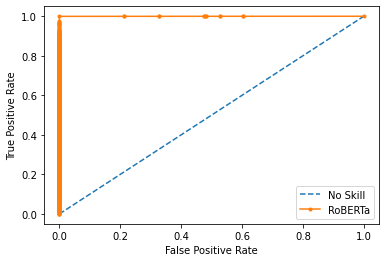

In [69]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RoBERTa')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()